In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv("path_to_file")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
for i in df.columns:
    if (df[i].dtype == 'object'):
        print(f'Unique Values in {i}: \n', df[i].unique(), '\n')

In [ ]:
from AutoClean import AutoClean
pipeline = AutoClean(df)

In [ ]:
AutoClean(df, mode='auto', duplicates=False, missing_num=False, missing_categ=False, 
          encode_categ=False, extract_datetime=False, outliers=False, outlier_param=1.5, 
          logfile=True, verbose=False)

### Autoclean: https://github.com/elisemercury/AutoClean
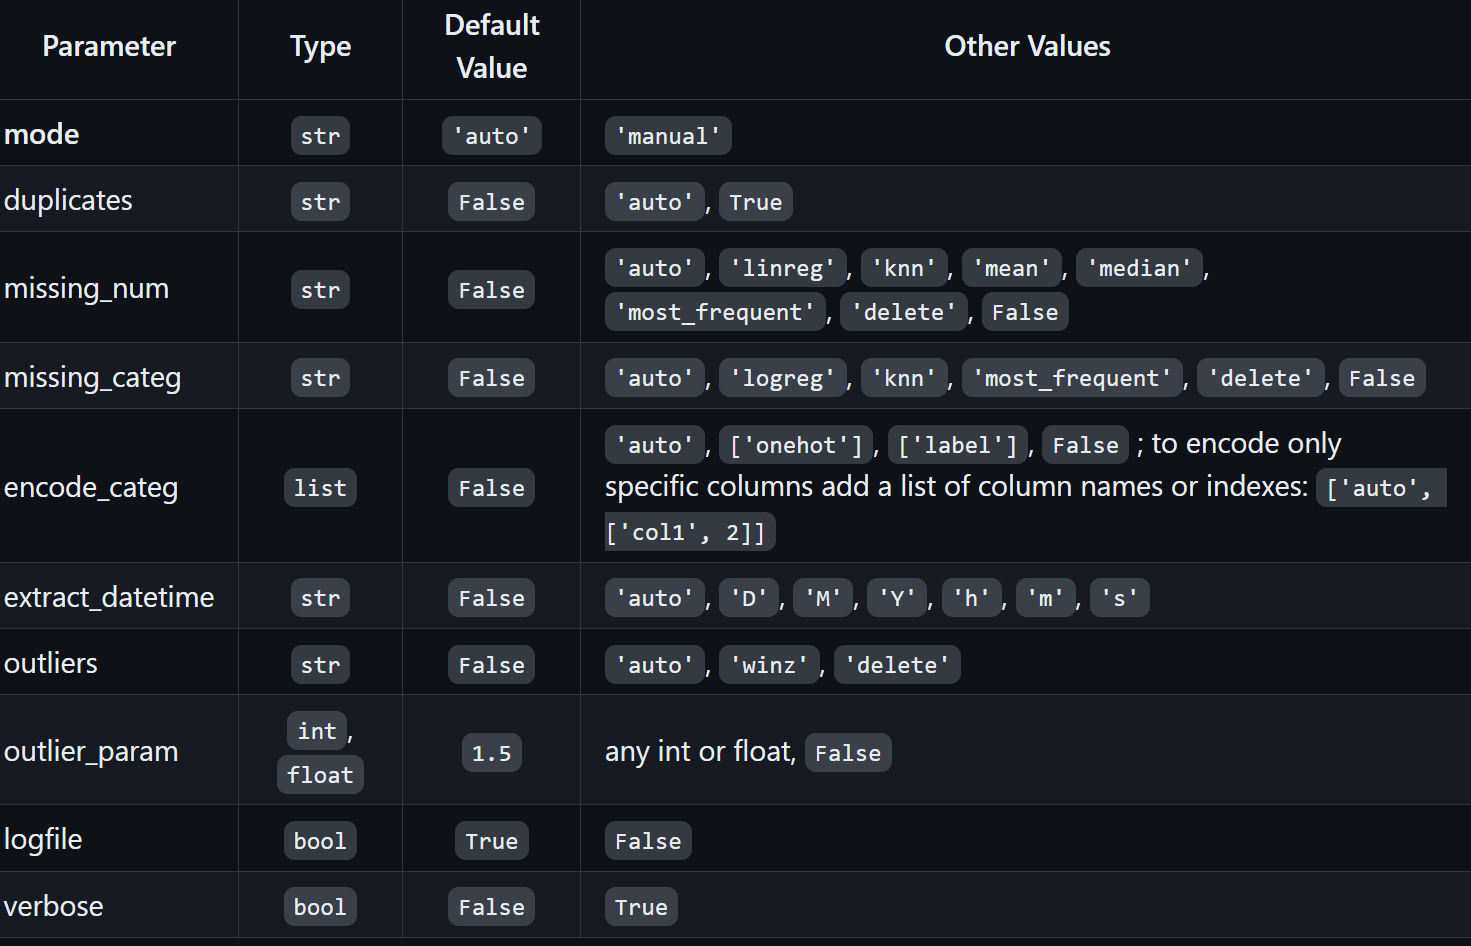

In [ ]:
df_processed = pipeline.output

In [ ]:
def plot_feature_distributions(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Plot the distribution of the current feature
        plt.figure()
        plt.hist(df[column], bins=30, edgecolor='k')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {column}')
        plt.show()

In [ ]:
plot_feature_distributions(df_processed)

In [ ]:
pairplot_map = df_processed.corr()
top_corr_features = pairplot_map.index
plt.figure(figsize = (30, 30))

hm =sns.heatmap(df_processed[top_corr_features].corr(), annot = True)

In [ ]:
X = df.drop('target_name', axis = 1)
y = df['target name']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
sc = StandardScaler() # Scaling for scale dependent algorithms
X_train_stand = sc.fit_transform(X_train)
X_test_stand = sc.fit_transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Based on number of components
pca = PCA(n_components=2)

principal_components = pca.fit_transform(X)
X_fit = pca.fit_transform(X)

In [ ]:
# Based on percent of explained variance

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(X)

df = pd.DataFrame(data=principal_components)

In [ ]:
# Interpret PCA

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3']) # Adjust based on number of principal components

# Concatenate the principal components and original data DataFrames
df_combined = pd.concat([df_pca, df_processed], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_combined.corr()

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Cardinality reduction for categorical variables
from collections import Counter

def cumulatively_categorise(column,threshold=0.85,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

In [ ]:
df_processed['new_column'], new_category_list = cumulatively_categorise(df_processed['original_column'], threshold = 0.95,return_categories_list=True)

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_stand, X_test_stand, y_train, y_test)
print(models)

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1.0, 10.0],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

logreg_model = LogisticRegression()

random_search = RandomizedSearchCV(estimator=logreg_model, param_distributions=param_grid, cv=5, n_iter=20, scoring='accuracy')
random_search.fit(X_train_stand, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the logistic regression model with the best hyperparameters
best_logreg_model = LogisticRegression(**best_params)
best_logreg_model.fit(X_train_stand, y_train)

# Make predictions on the test set
y_pred = best_logreg_model.predict(X_test_stand)
y_train_pred = best_logreg_model.predict(X_train_stand)
# Calculate evaluation metrics
print("Test Metrics: ")
print(classification_report(y_test,y_pred))
print("Train Metrics: ")
print(classification_report(y_train, y_train_pred))

In [ ]:
coefficients = best_logreg_model.coef_

# Get the feature names
feature_names = df.columns

# Create a bar chart of the coefficients
plt.bar(feature_names, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Coefficients')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

dt_model = DecisionTreeClassifier()

random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_grid, cv=5, n_iter=20, scoring='accuracy')
random_search.fit(X_train_stand, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Decision Tree classifier with the best hyperparameters
best_dt_model = DecisionTreeClassifier(**best_params)
best_dt_model.fit(X_train_stand, y_train)

# Make predictions on the test set
y_pred = best_dt_model.predict(X_test_stand)
y_train_pred = best_dt_model.predict(X_train_stand)

# Calculate evaluation metrics
print("Test Metrics:")
print(classification_report(y_test, y_pred))
print("Train Metrics:")
print(classification_report(y_train, y_train_pred))

In [ ]:
# Feature Importances for relative importance
feat_imp = pd.Series(best_dt_model.feature_importances_, index = X.columns)
feat_imp.plot(kind = 'barh')
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [100, 200, 500],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', 'auto']}

rf_model = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, n_iter=20, scoring='neg_mean_squared_error')
random_search.fit(X_train_stand, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Random Forest regressor with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_stand, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_stand)
y_train_pred = best_rf_model.predict(X_train_stand)

# Calculate evaluation metrics
print("Test Metrics:")
print(classification_report(y_test, y_pred))
print("Train Metrics:")
print(classification_report(y_train, y_train_pred))

In [ ]:
# Feature Importances for relative importance
feat_imp = pd.Series(best_rf_model.feature_importances_, index = X.columns)
feat_imp.plot(kind = 'barh')
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0],
              'algorithm': ['SAMME', 'SAMME.R']}

adaboost_model = AdaBoostClassifier()

random_search = RandomizedSearchCV(estimator=adaboost_model, param_distributions=param_grid, cv=5, n_iter=20, scoring='accuracy')
random_search.fit(X_train_stand, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the AdaBoost classifier with the best hyperparameters
best_adaboost_model = AdaBoostClassifier(**best_params)
best_adaboost_model.fit(X_train_stand, y_train)

# Make predictions on the test set
y_pred = best_adaboost_model.predict(X_test_stand)
y_train_pred = best_adaboost_model.predict(X_train_stand)

# Calculate evaluation metrics
print("Test Metrics:")
print(classification_report(y_test, y_pred))
print("Train Metrics:")
print(classification_report(y_train, y_train_pred))

In [ ]:
# Feature Importances for relative importance
feat_imp = pd.Series(best_adaboost_model.feature_importances_, index = X.columns)
feat_imp.plot(kind = 'barh')
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
from xgboost import XGBClassifier

param_grid = {'n_estimators': [100, 200, 500],
              'learning_rate': [0.01, 0.1, 1.0],
              'max_depth': [3, 5, 7],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'gamma': [0, 0.1, 0.2],
              'reg_alpha': [0, 0.1, 0.5],
              'reg_lambda': [0, 0.1, 1.0],
              'min_child_weight': [1, 5, 10]}

xgb_model = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=5, n_iter=20, scoring='accuracy')
random_search.fit(X_train_stand, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the XGBoost classifier with the best hyperparameters
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train_stand, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test_stand)
y_train_pred = best_xgb_model.predict(X_train_stand)

# Calculate evaluation metrics
print("Test Metrics:")
print(classification_report(y_test, y_pred))
print("Train Metrics:")
print(classification_report(y_train, y_train_pred))

In [ ]:
# Feature Importances for relative importance
feat_imp = pd.Series(best_xgb_model.feature_importances_, index = X.columns)
feat_imp.plot(kind = 'barh')
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature')
plt.show()